In [20]:
import sys
sys.path.append('../code')
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sbi import inference as sbi_inference
from utils import (linear_scale_forward, run_rc_sim, UniformPrior, linear_scale_array,
                   get_dataset_psd, get_dataset_peaks, load_posterior)
import dill
from sbi import utils as sbi_utils
import pandas as pd
sns.set()
sns.set_style("white")

device = 'cpu'
data_path = '../data/rc_circuit'

with open(f'{data_path}/posteriors/rc_posterior_dicts.pkl', 'rb') as output_file:
    posterior_state_dicts = dill.load(output_file)
with open(f'{data_path}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)
with open(f'{data_path}/sbi_sims/sim_metadata.pkl', 'rb') as output_file:
    sim_metadata = dill.load(output_file)
with open(f'{data_path}/posteriors/rc_posterior_metadata.pkl', 'rb') as output_file:
    posterior_metadata = dill.load(output_file)
    
dt = sim_metadata['dt'] # Sampling interval used for simulation
tstop = sim_metadata['tstop'] # Sampling interval used for simulation

t_vec = np.linspace(0, tstop, np.round(tstop/dt).astype(int))

In [12]:
# Parameter bounds
for param_name, param_dict in prior_dict.items():
    print(f'{param_name}:{param_dict["bounds"]}', end=' ')

amp1:(0, 1) amp2:(-1, 0) latency:(-20, 20) 

### Generate conditioning waveform

In [23]:
# Values on [0,1] mapped to range of bounds defined in prior_dict
theta_cond = np.array([0.5, 0.5, 0.7]) 

theta_dict = {param_name: param_dict['scale_func'](theta_vals[idx], param_dict['bounds']) for 
              idx, (param_name, param_dict) in enumerate(prior_dict.items())}
x_cond = run_rc_sim(theta_dict)
print(theta_dict)

{'amp1': 0.5, 'amp2': -0.5, 'latency': 8.0}


Text(0, 0.5, 'Voltage (V)')

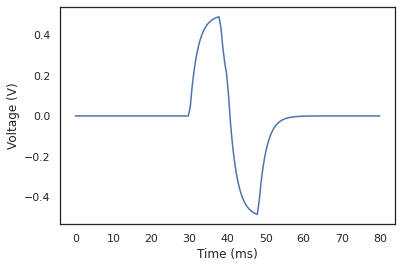

In [24]:
%matplotlib inline
plt.plot(t_vec, x_cond)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')

### Load trained posterior objects

In [45]:
prior = UniformPrior(parameters=list(prior_dict.keys()))
n_params = len(prior_dict)
limits = list(prior_dict.values())

# x_orig stores full waveform to be used for embedding
x_orig, theta_orig = np.load(f'{data_path}/sbi_sims/x_sbi.npy'), np.load(f'{data_path}/sbi_sims/theta_sbi.npy')
x_orig_peak = get_dataset_peaks(x_orig)
x_cond_peak = get_dataset_peaks(x_cond.T)

fs = posterior_metadata['fs'] # Frequency defined for PSD
x_orig_psd, f = get_dataset_psd(x_orig, fs=fs)
x_cond_psd, f = get_dataset_psd(x_cond.T, fs=fs)


load_info = {'raw_waveform_noise': {'x_train': x_orig, 'x_cond': x_cond},
                   'peak_noise': {'x_train': x_orig_peak, 'x_cond': x_cond_peak},
                   'psd_noise': {'x_train': x_orig_psd, 'x_cond': x_cond_psd}}

posterior_names = list(posterior_state_dicts.keys())
print(posterior_names)

['rc_raw_waveform_noise', 'rc_peak_noise', 'rc_psd_noise']


In [50]:
name_idx = 2 # Pick posterior to load

name = posterior_names[name_idx]
posterior_dict = posterior_state_dicts[name]
state_dict = posterior_dict['posterior']
n_params = posterior_dict['n_params']
input_type = posterior_dict['input_type']
n_sims = posterior_dict['n_sims']
input_dict = posterior_dict['input_dict']

embedding_net =  input_dict['embedding_func'](**input_dict['embedding_dict'])

posterior = load_posterior(state_dict=state_dict,
                           x_infer=torch.tensor(load_info[input_type]['x_train'][:10,:]).float(),
                           theta_infer=torch.tensor(theta_orig[:10,:]), prior=prior, embedding_net=embedding_net)

### Draw samples and plot

Conditioning Feature: rc_psd_noise


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

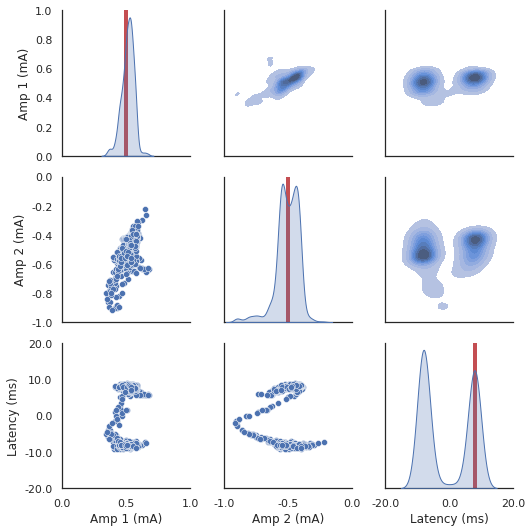

In [52]:
print(f'Conditioning Feature: {posterior_names[name_idx]}')
num_samples = 1000

all_labels = ['Amp 1 (mA)', 'Amp 2 (mA)', 'Latency (ms)']
all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]

samples = posterior.sample((num_samples,), x=torch.tensor(load_info[input_type]['x_cond'].squeeze()))
samples_transformed = linear_scale_array(samples.numpy(), all_bounds)

theta_cond_transformed = list(theta_dict.values())

df_dict = {name: samples_transformed[:, idx] for idx, name in enumerate(all_labels)}

df = pd.DataFrame(df_dict)

g = sns.PairGrid(df,  diag_sharey=False)
g.map_lower(sns.scatterplot)
g.map_upper(sns.kdeplot, fill=True)
g.map_diag(sns.kdeplot, fill=True)

for idx in range(3):
    g.axes[idx, idx].axvline(theta_cond_transformed[idx], color='r', linewidth=4) 
    g.axes[idx, idx].set_xlim(all_bounds[idx])
    g.axes[idx, idx].set_ylim(all_bounds[idx])

for idx1 in range(3):
    for idx2 in range(3):
        g.axes[idx1, idx2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        g.axes[idx1, idx2].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tight_layout()